# Agentic Workflow Example #2 -- Single Agent & Multiple Tools Use

So far we have seen how to use the Agent to interact with a single tool. However, in many cases, **a single tool is not enough to accomplish a task**.

We have been creating **very specific tools** for the Agent to use. In this example, we will demonstrate how agents can interact with **multiple tools** in a single workflow.

In [ ]:
import sys

sys.path.append("..")

import nest_asyncio

nest_asyncio.apply()

from src.schema import (
    Customer,
    Order,
    OrderItem,
    Product
)
from pathlib import Path
import csv
from IPython.display import display, SVG, Markdown

API_KEY = '<enter your API key>'

## Data Import

The company has some **CSV files** regarding the `customers`, `products`, `orders` nad `order_items` tables. You have been given the following files:
- `src/assets/customers.csv`

- `src/assets/products.csv`

- `src/assets/orders.csv`

- `src/assets/order_items.csv`

In [24]:
from src.utils import init_db

BASE_ASSETS_PATH = Path("..") / "src" / "assets"

with (BASE_ASSETS_PATH / "customers.csv").open("r") as f:
    customers = [
        Customer.model_validate(row)
        for row in csv.DictReader(f)
    ]

with (BASE_ASSETS_PATH / "products.csv").open("r") as f:
    products = [
        Product.model_validate(row)
        for row in csv.DictReader(f)
    ]

with (BASE_ASSETS_PATH / "orders.csv").open("r") as f:
    orders = [
        Order.model_validate(row)
        for row in csv.DictReader(f)
    ]

with (BASE_ASSETS_PATH / "order_items.csv").open("r") as f:
    order_items = [
        OrderItem.model_validate(row)
        for row in csv.DictReader(f)
    ]

await init_db(
    BASE_ASSETS_PATH / "database.db",
    *customers,
    *products,
    *orders,
    *order_items
)

### Entity-Relationship Diagram (ERD)

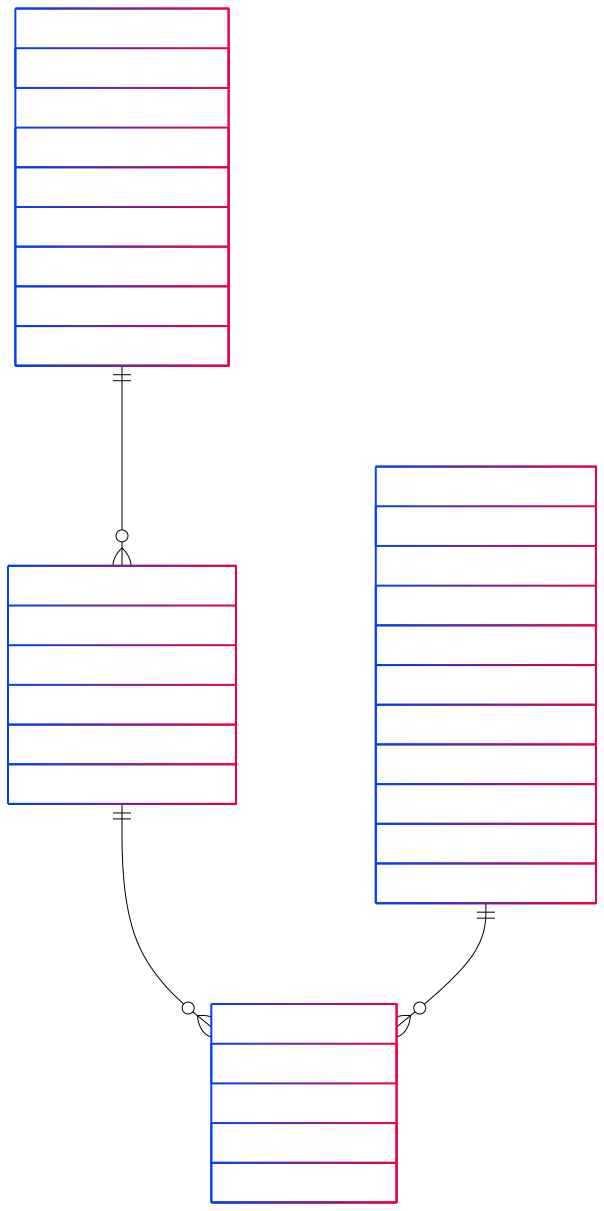

In [25]:
display(SVG(filename='pictures/er-diagram.svg'))

## Task

Your management team is quite satisfied with your work on the internal QA. Yet they want the bot to do more on the **customers** and **sales data**.

As the management team doesn't have high expectations, they are currently interested in the following questions:
- `Get me the shopping categories proportions of user Queenie Sit, including the category name and the quantity of each category`

- `Get me the revenue of orders from user Queenie Sit`

In [ ]:
from pydantic import BaseModel, ConfigDict
from pydantic_ai import Agent, RunContext
from src.utils import session_connect
from sqlalchemy.ext.asyncio import AsyncEngine, create_async_engine
from sqlmodel import select
import sqlalchemy as sa
from pydantic_ai.models.openai import OpenAIModel
from pydantic_ai.providers.openai import OpenAIProvider
import uuid

In [27]:
# Don't change the following!

class BusinessAnalysisDeps(BaseModel):
    """Dependencies for the BusinessAnalysis agent."""
    model_config = ConfigDict(arbitrary_types_allowed=True)
    
    # Object-relational mapping engine that can pass to the `session_connect` function
    engine: AsyncEngine

## Analysis

When creating complicated workflows, it is important to **analyze the execution flow** of the tasks.

For the first question of `Get me the shopping categories proportions of user Queenie Sit, including the category name and the quantity of each category`, we need to:
- Get the user ID of `Queenie Sit` from the `customers` table
- Get the order IDs of `Queenie Sit` from the `orders` table
- Get the **sum of ordered quantity** of each category from the `order_items` table for every order ID

<br>

For the second question of `Get me the revenue of orders from user Queenie Sit`, we need to:
- Get the user ID of `Queenie Sit` from the `customers` table
- Get the order IDs of `Queenie Sit` from the `orders` table
- Get the **sum of revenue** of each order from the `order_items` table for every order ID

<br>

We can see that these two questions all have the **same steps** of:
- Getting the user ID of a particular user from the `customers` table
- Getting the order IDs of a particular user from the `orders` table

In [28]:
# Don't change the following!

# You have seen this in example 1!
async def get_customer_info_from_name(
    ctx: RunContext[BusinessAnalysisDeps], first_name: str, last_name: str
) -> Customer | None:
    """
    Get existing customer info from first name and last name.
    """
    async with session_connect(ctx.deps.engine) as session:
        sql = select(Customer).where(
            sa.func.lower(Customer.first_name) == first_name.lower(),
            sa.func.lower(Customer.last_name) == last_name.lower(),
        )
        result = await session.exec(sql)
        customer = result.one_or_none()
        return customer

In [29]:
# Please fill in the following function

async def get_customer_all_orders(
    ctx: RunContext[BusinessAnalysisDeps], customer_id: uuid.UUID
) -> list[uuid.UUID]:
    """
    Get all order ids of a customer.
    """
    async with session_connect(ctx.deps.engine) as session:
        # what should be filled in here?
        sql = select(Order.id).where(
            Order.customer_id == customer_id,
        )
        results = await session.exec(sql)
        return results.all()

#### Hint:

The `get_customer_all_orders` should read like the following SQL:

```sql
SELECT o
FROM orders o
WHERE o.customer_id = <customer_id>
```

In [30]:
# Please fill in the following function

async def get_orders_sales_amount(
    ctx: RunContext[BusinessAnalysisDeps], *order_id: uuid.UUID
) -> float:
    """
    Get the sum of sales amount of all orders.
    """
    async with session_connect(ctx.deps.engine) as session:
        # what should be filled in here?
        sql = (
            select(sa.func.sum(OrderItem.quantity * Product.unit_price))
            .select_from(Order)
            .join(OrderItem, OrderItem.order_id == Order.id)
            .join(Product, OrderItem.product_id == Product.id)
            .where(Order.id.in_(order_id))
        )
        results = await session.exec(sql)
        return results.one_or_none() or 0.0

#### Hint:

The `get_orders_sales_amount` should read like the following SQL:

```sql
SELECT SUM(oi.quantity * p.unit_price) AS revenue
FROM order_items oi
JOIN products p ON oi.product_id = p.id
JOIN orders o ON oi.order_id = o.id
WHERE oi.order_id IN (<order_ids>)
```

In [31]:
# Don't change the following!

async def get_orders_categories(
    ctx: RunContext[BusinessAnalysisDeps], *order_id: uuid.UUID
) -> list[dict[str, str]]:
    """
    Get all ordered items categories purchased by a customer, including the total quantity of each category groupped.
    """
    async with session_connect(ctx.deps.engine) as session:
        sql = (
            select(Product.category, sa.func.sum(OrderItem.quantity).label("quantity"))
            .select_from(Order)
            .join(OrderItem, OrderItem.order_id == Order.id)
            .join(Product, OrderItem.product_id == Product.id)
            .where(Order.id.in_(order_id))
            .group_by(Product.category)
            .order_by(sa.func.sum(OrderItem.quantity).desc())
        )
        results = await session.exec(sql)
        categories = results.all()
        return [
            {
                "category": category,
                "quantity": quantity,
            }
            for category, quantity in categories
        ]

In [ ]:
model = OpenAIModel(
    'accounts/fireworks/models/qwq-32b',  # model library available at https://fireworks.ai/models
    provider=OpenAIProvider(
        base_url='https://api.fireworks.ai/inference/v1',
        api_key=API_KEY,
    ),
)

business_analysis_agent_2 = Agent(
    model=model,
    deps_type=BusinessAnalysisDeps,
    tools=[
        get_customer_info_from_name,
        get_customer_all_orders,
        get_orders_sales_amount,
        get_orders_categories
    ],
    system_prompt=(
        "You are a business analyst. You have access to a SQLite database "
        "that contains customer, order, and product information. "
        "You can use the tools provided to query the database and "
        "answer questions about the data."
        "Follow the instructions carefully and provide the most accurate "
        "and relevant information possible. Output the result in markdown format."
    )
)

engine = create_async_engine("sqlite+aiosqlite:///../src/assets/database.db")

In [ ]:
# Don't change the following!

result = await business_analysis_agent_2.run(
    "Get me the shopping categories proportions of user Queenie Sit, including the category name and the quantity of each category",
    deps=BusinessAnalysisDeps(engine=engine)
)
display(Markdown(result.data))

OK. Queenie Sit's shopping category proportions are: electronics: 241, home: 151, clothing: 132, and toys: 99.

In [ ]:
# Don't change the following!

result = await business_analysis_agent_2.run(
    "Get me the revenue of orders from user Queenie Sit",
    deps=BusinessAnalysisDeps(engine=engine)
)
display(Markdown(result.data))

The revenue of all orders from Queenie Sit is 1124605.

## How does the agent interacts with the tools?

For every `run` method, the agent will log all the steps it takes to accomplish the task by the `.all_messages()` method.

In [35]:
# Don't change the following!

import pprint

pprint.pprint(result.all_messages())

[ModelRequest(parts=[SystemPromptPart(content='You are a business analyst. You '
                                              'have access to a SQLite '
                                              'database that contains '
                                              'customer, order, and product '
                                              'information. You can use the '
                                              'tools provided to query the '
                                              'database and answer questions '
                                              'about the data.Follow the '
                                              'instructions carefully and '
                                              'provide the most accurate and '
                                              'relevant information possible. ',
                                      timestamp=datetime.datetime(2025, 4, 25, 19, 49, 22, 942647, tzinfo=datetime.timezone.utc),
                     

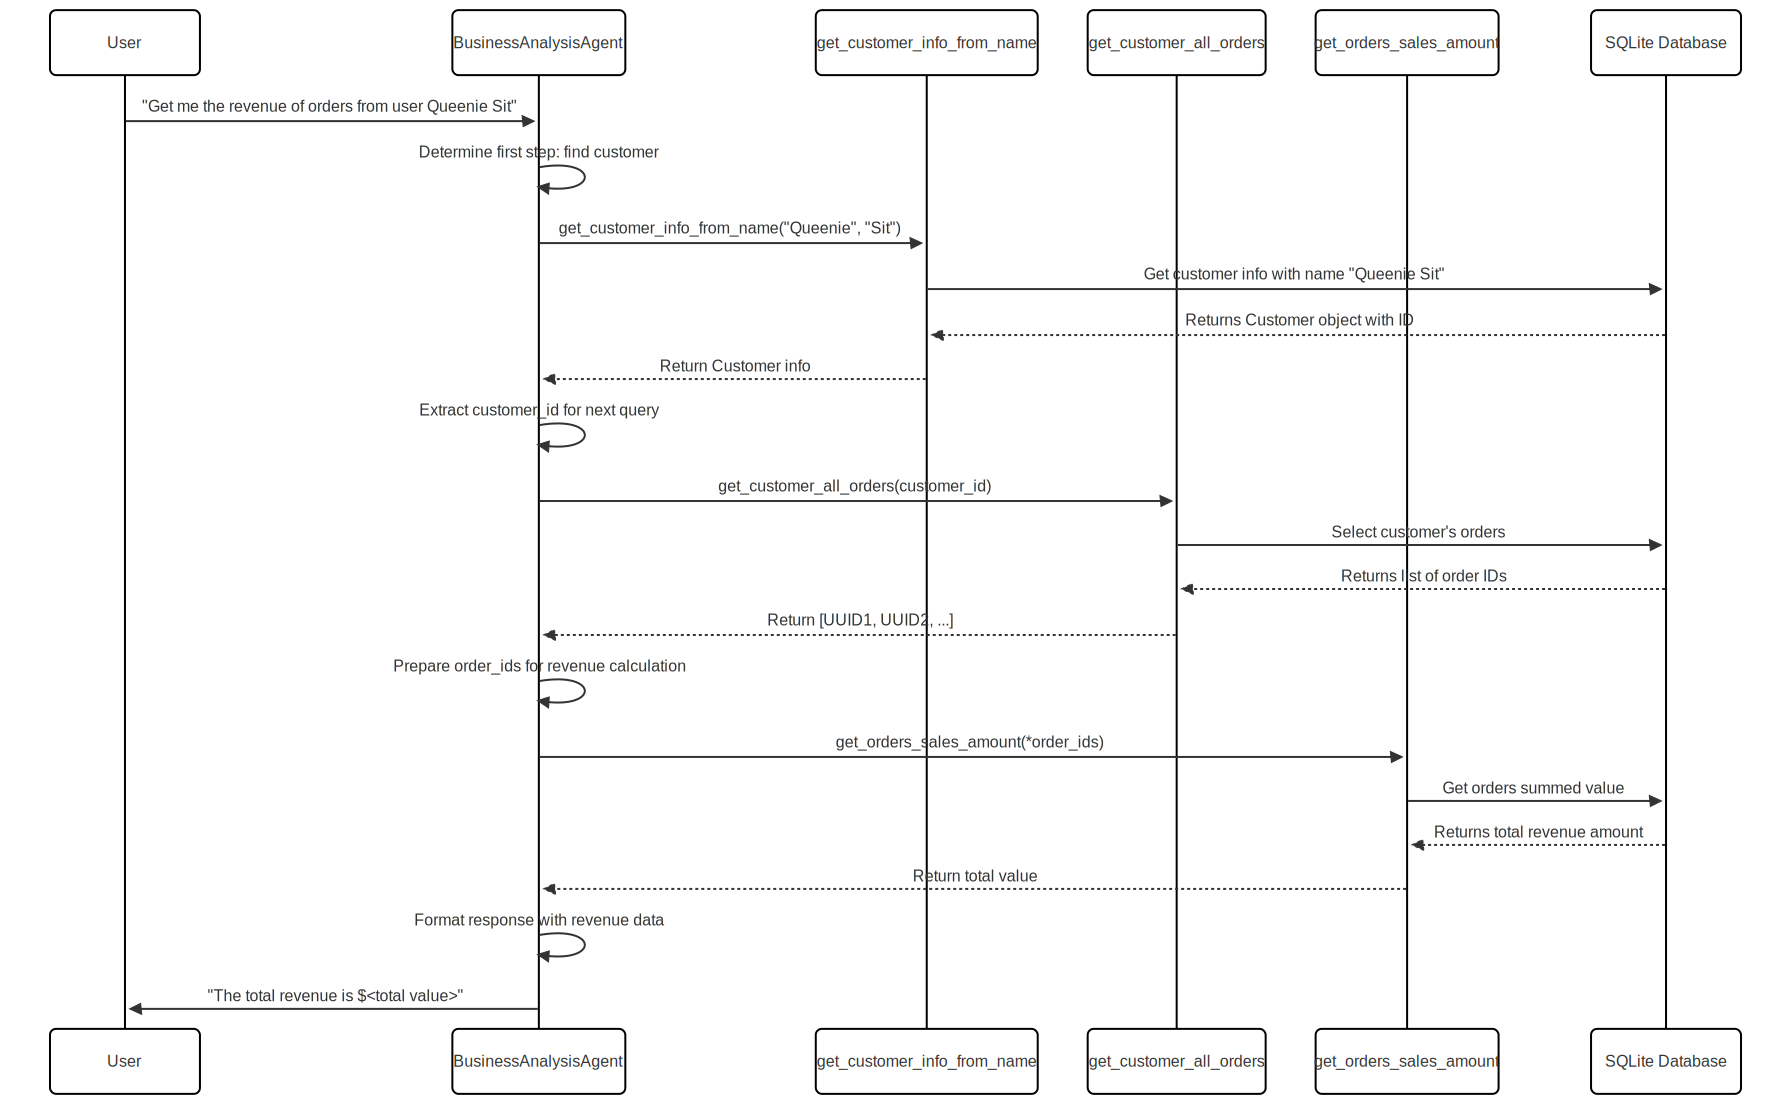

In [36]:
display(SVG(filename='pictures/agent-multiple-tools-interaction.svg'))